In [1]:
import pandas as pd
import os
import scanpy as sc
import anndata
import glob
import re
import numpy as np
import torch.nn.functional as F
import torch
import scipy.stats as stats
import umap
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import brewer2mpl
from statannotations.Annotator import Annotator
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42


/home/yipingzou2/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
tissue = {"HTO1": "PBMC", "HTO3": "PBMC", "HTO4": "PBMC","HTO5": "Adenoid",
          "HTO7": "Adenoid", "HTO9": "Adenoid", 
          "HTO6": "Tonsil", "HTO8": "Tonsil", "HTO10": "Tonsil"}

tissue = {"HTO1": "CNMC89", "HTO3": "CNMC99","HTO4": "CNMC71","HTO5": "CNMC71",
          "HTO7": "CNMC89", "HTO9": "CNMC99", 
          "HTO6": "CNMC71", "HTO8": "CNMC89", "HTO10": "CNMC99"}

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/yipingzou2/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


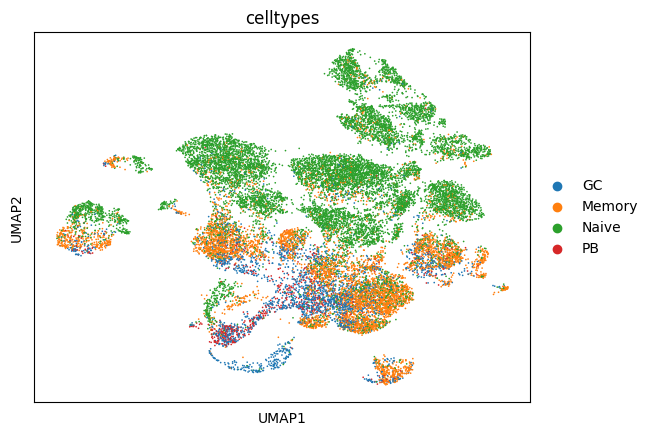

In [2]:
bcremb = pd.read_csv("/mnt/d/unifiedBCR/benchmark/Embeddings/PRJNA890633/mean_inner01.pth/embedding.csv").values
gexemb = pd.read_csv("/mnt/d/unifiedBCR/benchmark/Embeddings/PRJNA890633/mean_inner01.pth/gexembedding.csv").values
datapath = "/mnt/d/BCRdataset/PRJNA890633/integrated"
metadata = pd.read_csv("annotation.csv", index_col="barcode")
bcrfile_path = os.path.join(datapath, "processed_bcr.csv")
bcrfile = pd.read_csv(bcrfile_path, index_col="barcode")
bcrfile['whole_seq'] = bcrfile['fwr1'].str.cat([bcrfile["cdr1"], bcrfile["fwr2"], bcrfile["cdr2"], bcrfile["fwr3"],
                                               bcrfile["cdr3"], bcrfile["fwr4"]])
embeddings = np.concatenate([bcremb, gexemb], axis=1)
embeddings = torch.from_numpy(embeddings)
embeddings = F.normalize(embeddings, dim = -1).numpy()
new_adata = anndata.AnnData(embeddings)
new_adata.obs = metadata
new_adata.obs['cdr3'] = pd.read_csv("integrated/processed_bcr.csv").cdr3.tolist()
sc.pp.neighbors(new_adata, n_neighbors=10, n_pcs=30)
sc.tl.umap(new_adata)
sc.pl.umap(new_adata, color="celltypes")

In [3]:
bcrfile['c_gene'] = bcrfile['c_gene'].str.replace('\d', '', regex=True)
new_adata.obs['IGtype'] = bcrfile['c_gene']
new_adata.obs.loc[bcrfile.index.tolist(), 'whole_seq'] = bcrfile['whole_seq']
new_adata.obs.loc[bcrfile.index.tolist(), 'v_gene'] = bcrfile['v_gene']
new_adata.obs.loc[bcrfile.index.tolist(), 'j_gene'] = bcrfile['j_gene']
new_adata.obs.loc[bcrfile.index.tolist(), 'c_gene'] = bcrfile['c_gene']
new_adata.obs['v_gene_family'] = new_adata.obs['v_gene'].str.split('/').str[0].str.extract(r'(IGH[VDJ]\d+)')[0]
new_adata.obs['j_gene_family'] = new_adata.obs['j_gene'].str.split('/').str[0].str.extract(r'(IGH[VDJ]\d+)')[0]
seq_counts = new_adata.obs['whole_seq'].value_counts()
seq_to_id = {seq: f'bcrseq{i+1}' for i, seq in enumerate(seq_counts.index)}
new_adata.obs['whole_seq_label'] = new_adata.obs['whole_seq'].map(seq_to_id)
top20_labels = new_adata.obs['whole_seq_label'].value_counts().head(20).index.tolist()
new_adata.obs['whole_seq_top20'] = new_adata.obs['whole_seq_label'].apply(
    lambda x: x if x in top20_labels else 'Others'
)
# add shm information
vdjcall = pd.read_csv('vdjcall.csv', index_col='barcode')
vdjcall = vdjcall[vdjcall.chain == 'IGH']
shm_dict = (100 - vdjcall['v_identity']).to_dict()
new_adata.obs['heavy_shm'] = new_adata.obs.index.map(shm_dict)

/home/yipingzou2/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


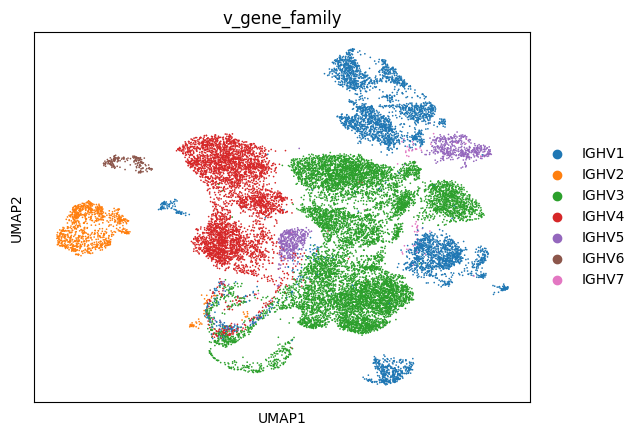

In [5]:
sc.pl.umap(new_adata, color="v_gene_family", palette = 'Set2', show=False)
plt.savefig("/mnt/d/unifiedBCR/figures/PRJNA890633/3modalities/combcr_v_gene_family.pdf", bbox_inches='tight')

/home/yipingzou2/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


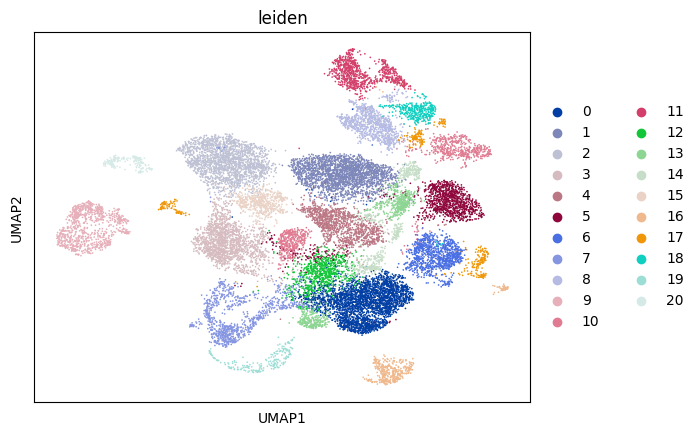

In [6]:
sc.tl.leiden(new_adata, resolution=0.5)
sc.pl.umap(new_adata, color="leiden", show=False)
plt.savefig("/mnt/d/unifiedBCR/figures/PRJNA890633/3modalities/combcr_leiden.pdf", bbox_inches='tight')

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/yipingzou2/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


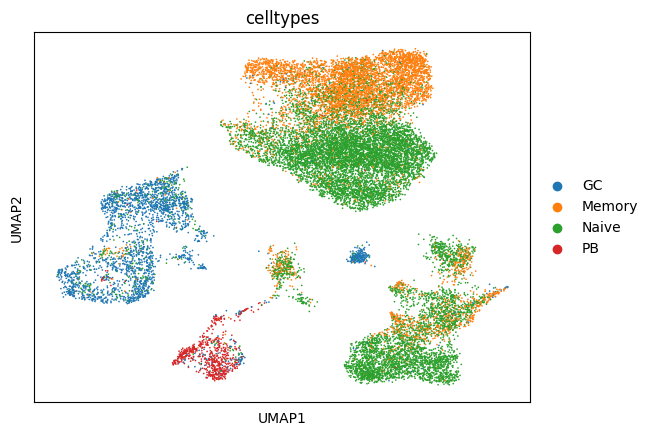

In [8]:
datapath = "/mnt/d/BCRdataset/PRJNA890633/integrated"
rnafile_path = os.path.join(datapath, "processed_rna.csv")
rnafile = pd.read_csv(rnafile_path, index_col="barcode")
originalgex= anndata.AnnData(rnafile)
originalgex.obs = new_adata.obs
sc.pp.neighbors(originalgex, n_neighbors=10, n_pcs=30)
sc.tl.umap(originalgex)
sc.pl.umap(originalgex, color='celltypes', show=False)
plt.savefig("/mnt/d/unifiedBCR/figures/PRJNA890633/3modalities/original_celltypes.pdf", bbox_inches='tight')

/home/yipingzou2/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


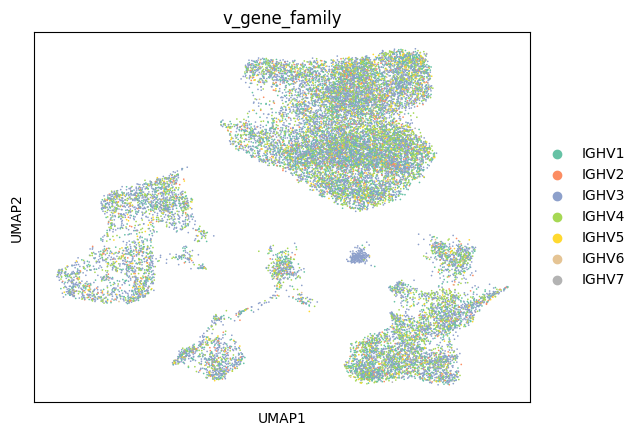

In [9]:
sc.pl.umap(originalgex, color='v_gene_family', palette = 'Set2', show=False)
plt.savefig("/mnt/d/unifiedBCR/figures/PRJNA890633/3modalities/original_v_gene_family.pdf", bbox_inches='tight')

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/yipingzou2/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


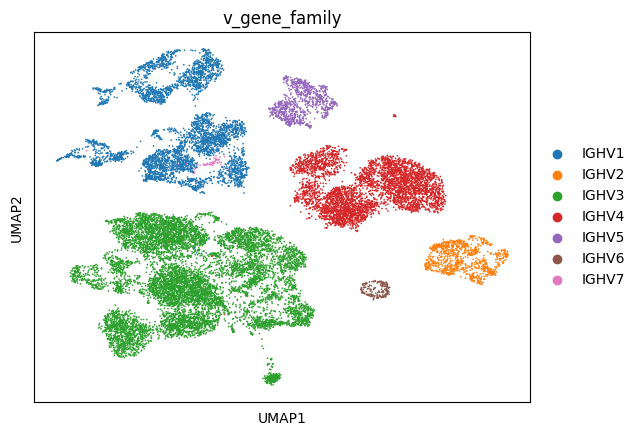

In [6]:
datapath = "/mnt/d/BCRdataset/PRJNA890633/integrated"
antiberta2 = pd.read_csv(os.path.join(datapath, 'antiberta2', 'antiberta_CSSP_embedding.csv'), index_col="barcode")
antiberta2 = anndata.AnnData(antiberta2.values)
antiberta2.obs = new_adata.obs
sc.pp.neighbors(antiberta2, n_neighbors=10, n_pcs=30)
sc.tl.umap(antiberta2)
sc.pl.umap(antiberta2, color='v_gene_family', palette = 'Set2', show=False)
plt.savefig("/mnt/d/unifiedBCR/figures/PRJNA890633/3modalities/antiberta2_v_gene_family.pdf", bbox_inches='tight')

/home/yipingzou2/.local/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


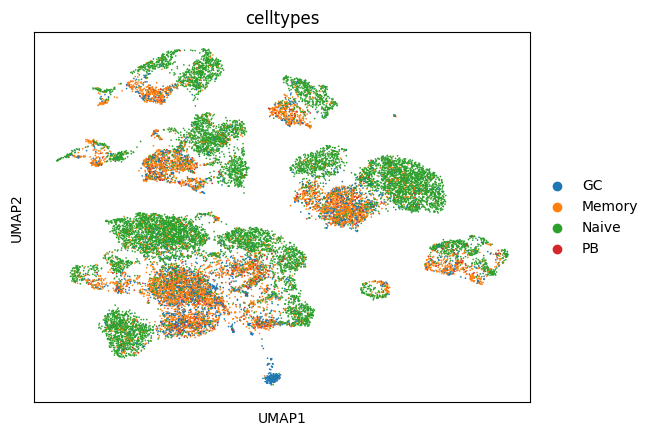

In [24]:
sc.pl.umap(antiberta2, color='celltypes', show=False)
plt.savefig("/mnt/d/unifiedBCR/figures/PRJNA890633/3modalities/antiberta2_celltypes.pdf", bbox_inches='tight')

In [117]:
gap = pd.DataFrame({'gap': (torch.cdist(torch.from_numpy(bcremb), torch.from_numpy(gexemb))).diagonal().numpy(), 
                     'celltypes':metadata.celltypes.tolist(), 'IGtype':new_adata.obs['IGtype'].tolist()})
gap['barcode'] = metadata.index.tolist()
gap['sample'] = metadata['sample'].tolist()
gap = gap.set_index('barcode', inplace=False)
#sns.violinplot(data=gap, x='celltypes', y='gap')
gap = gap.sort_values(by="gap", ascending=False)
threshold = gap['gap'].quantile(0.9)
gap['difference'] = 'Small'
gap.loc[gap['gap'] >= threshold, 'difference'] = 'Large'
grouped_df = gap.groupby(['celltypes', 'difference']).size().unstack(fill_value=0)
gap.loc[gap['gap'] >= threshold, 'difference'] = 'Large'
new_adata.obs.loc[gap.index.tolist(), 'difference'] = gap['difference']
new_adata.obs.loc[gap.index.tolist(), 'gap_value'] = gap['gap']
#sns.violinplot(data=gap, x='celltypes', y='gap')

<AxesSubplot: ylabel='Density'>

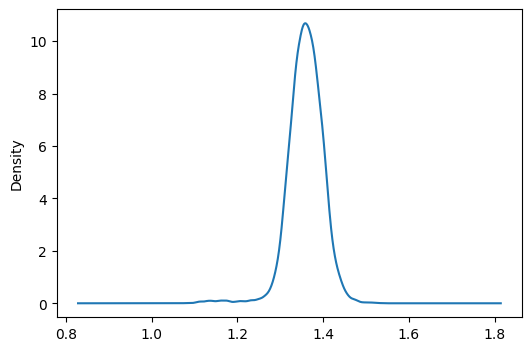

In [5]:
fig, axes = plt.subplots(figsize=(6,4))
gap['gap'].plot.kde(ax=axes)
#plt.savefig("/mnt/d/unifiedBCR/figures/PRJNA890633/gap_distribution.pdf", bbox_inches='tight')

/tmp/ipykernel_912843/1176377414.py:9: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=new_adata.obs,


Spearman Correlation (R): -0.082762
P-value: 8.14e-33


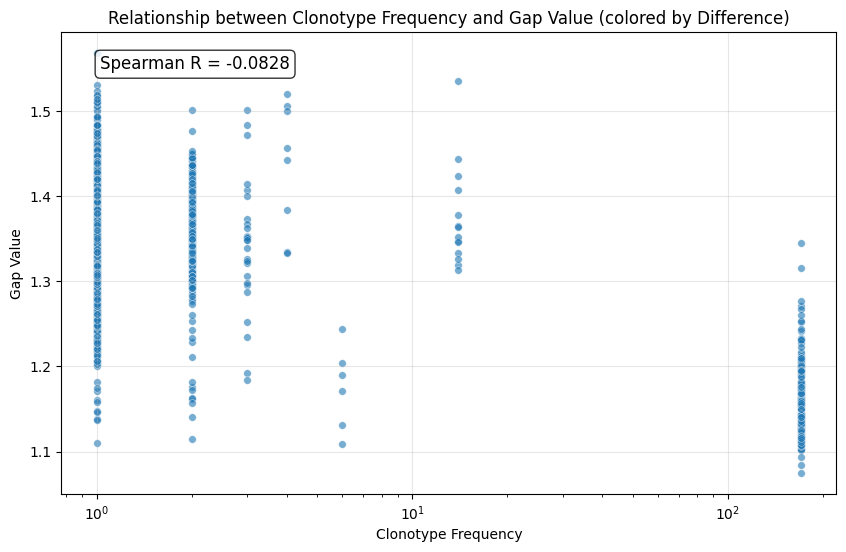

In [ ]:
from scipy.stats import spearmanr

# Calculate correlation coefficient
correlation, p_value = spearmanr(new_adata.obs['clonotype.freq'].values, 
                                new_adata.obs['gap_value'].values)

# Create scatter plot using seaborn
plt.figure(figsize=(10, 6))
sns.scatterplot(data=new_adata.obs, 
                x='clonotype.freq', 
                y='gap_value',
                #hue='tissue',
                alpha=0.6, 
                s=30,
                palette= ['#3498db', '#e74c3c', '#2ecc71', '#f39c12'])  # Custom colors
plt.xscale('log')

# Add correlation coefficient information
plt.text(0.05, 0.95, f'Spearman R = {correlation:.4f}', 
         transform=plt.gca().transAxes, fontsize=12, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8),
         verticalalignment='top')

plt.xlabel('Clonotype Frequency')
plt.ylabel('Gap Value')
plt.title('Relationship between Clonotype Frequency and Gap Value (colored by Difference)')
plt.grid(True, alpha=0.3)
print(f"Spearman Correlation (R): {correlation:.6f}")
print(f"P-value: {p_value:.2e}")
plt.savefig("/mnt/d/unifiedBCR/figures/PRJNA890633/gap_clonotype_freq.pdf", bbox_inches='tight')

/tmp/ipykernel_96095/3303648838.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plotdf = plotdf.pivot("sample", "celltypes", "ratio")


<AxesSubplot: xlabel='celltypes', ylabel='sample'>

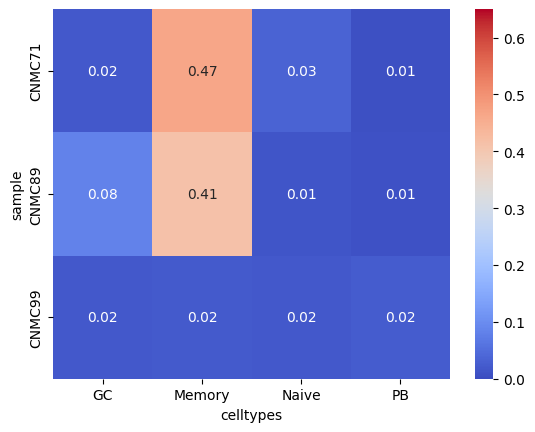

In [5]:
grouped_df = new_adata.obs.groupby(['sample', 'celltypes', 'batch']).size().unstack(fill_value=0)
grouped_df['spike-'] = grouped_df[7] + grouped_df[8]
grouped_df = grouped_df.rename(columns={6: 'spike+'})
grouped_df['ratio'] = grouped_df['spike+'] / (grouped_df['spike+'] + grouped_df['spike-'])

plotdf = pd.DataFrame(columns=['sample', "celltypes", "ratio"])
i = 0
for sampleID, celltype in grouped_df.index.tolist():
    plotdf.at[i, 'sample'] = sampleID
    plotdf.at[i, 'celltypes'] = celltype
    plotdf.at[i, 'ratio'] = grouped_df[grouped_df.index == (sampleID, celltype)].ratio.values[0]
    i += 1
plotdf = plotdf.pivot("sample", "celltypes", "ratio")
plotdf = plotdf[plotdf.columns].astype(float)
sns.heatmap(data=plotdf, annot = True, fmt='.2f', cmap="coolwarm", vmin=0, vmax=0.65)
#plt.savefig("/mnt/d/unifiedBCR/figures/PRJNA890633/S+vs.S-.pdf", bbox_inches='tight')

/tmp/ipykernel_96095/390667462.py:15: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  plotdf = plotdf[plotdf['difference']=='Large'].pivot("sample", "celltypes", "ratio")


<AxesSubplot: xlabel='celltypes', ylabel='sample'>

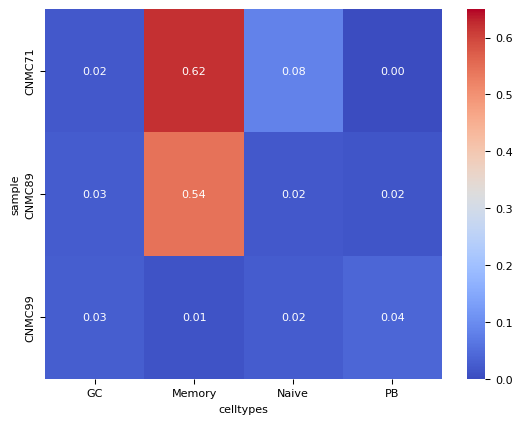

In [8]:
grouped_df = new_adata.obs.groupby(['sample', 'celltypes', 'difference', 'batch']).size().unstack(fill_value=0)
grouped_df['spike-'] = grouped_df[7] + grouped_df[8]
grouped_df = grouped_df.rename(columns={6: 'spike+'})
grouped_df['ratio'] = grouped_df['spike+'] / (grouped_df['spike+'] + grouped_df['spike-'])

# Large
plotdf = pd.DataFrame(columns=['sample', "celltypes", "difference", "ratio"])
i = 0
for sampleID, celltype, difference in grouped_df.index.tolist():
    plotdf.at[i, 'sample'] = sampleID
    plotdf.at[i, 'celltypes'] = celltype
    plotdf.at[i, 'difference'] = difference
    plotdf.at[i, 'ratio'] = grouped_df[grouped_df.index == (sampleID, celltype, difference)].ratio.values[0]
    i += 1
plotdf = plotdf[plotdf['difference']=='Large'].pivot("sample", "celltypes", "ratio")
plotdf = plotdf[plotdf.columns].astype(float)
sns.heatmap(data=plotdf, annot = True, fmt='.2f', cmap="coolwarm", vmin=0, vmax=0.65)
#plt.savefig("/mnt/d/unifiedBCR/figures/PRJNA890633/Large:S+vs.S-.pdf", bbox_inches='tight')

In [80]:
adata = sc.read_h5ad("integrated/raw_count.h5ad")
#adata.raw = adata
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
assert(adata.obs.index.tolist() == new_adata.obs.index.tolist())
adata.obs = new_adata.obs
proligenes = ["MKI67", "PLK1", "E2F1", "FEN1", "FOXM1", "MCM2", "MCM7", "BUB1", "CCNE1", "CCND1", 
             "CCNB1", "TOP2A", "MYBL2", "BUB1", "PLK1", "ZWINT", "TYMS", "PCNA", "H2AFZ", "HMGB2", 
             "TCL1A", "CD79B", "CD79A", "MS4A1"]
exhaustgenes = ['FCRL4', 'PDCD1', 'SIGLEC6', 'LAIR1', 'CXCR3', 'CD38', 'CD70', 'CD72', 'CD22']
activategenes = ['CD69', 'CD83', 'IER2', 'DUSP2', 'IL6', 'NR4A2', 'JUN', 'CCR7', 'GPR183', 'IRF4', 'MYC']

(-0.4434631675459671, 1.0844390465864535)

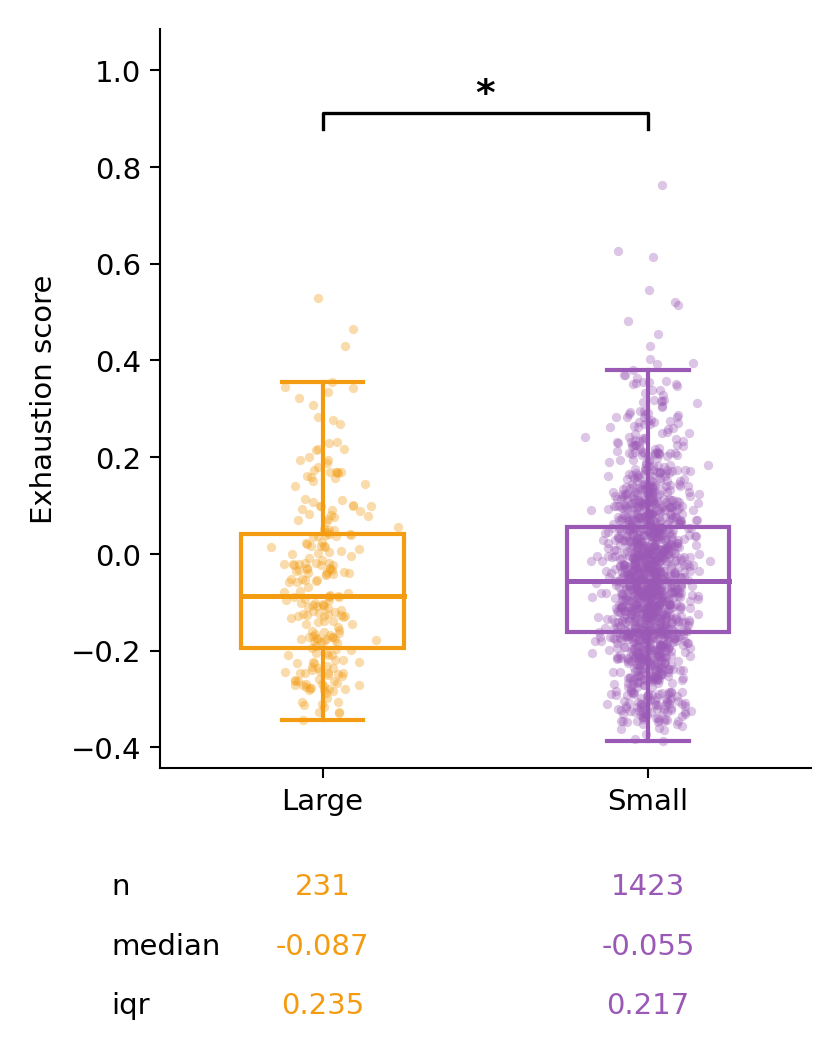

In [81]:
cohort1 = new_adata.obs[
    (new_adata.obs['sample'].isin(["CNMC89", "CNMC71"])) &
    (new_adata.obs.celltypes == "Memory") &
    (new_adata.obs.difference == "Large") &
    (new_adata.obs.batch == 6)
].index.tolist()

cohort2 = new_adata.obs[
    (new_adata.obs['sample'].isin(["CNMC89", "CNMC71"])) &
    (new_adata.obs.celltypes == "Memory") &
    (new_adata.obs.difference == "Small") &
    (new_adata.obs.batch == 6)
].index.tolist()

subobj = adata[cohort1 + cohort2].copy()
sc.tl.score_genes(subobj, exhaustgenes)  # creates subobj.obs["score"]

# Nature-style rcParams
plt.rcParams.update({
    'font.size': 7,
    'axes.linewidth': 0.5,
    'xtick.major.width': 0.5,
    'ytick.major.width': 0.5,
    'xtick.major.size': 2.5,
    'ytick.major.size': 2.5,
    'legend.frameon': False,
    'legend.fontsize': 6
})

fig, ax = plt.subplots(figsize=(2.8, 3.2), dpi=300)

# Data preparation
colors = {'Large': '#F39C12', 'Small': '#9B59B6'}
order = ['Large', 'Small']

data_dict = {
    cat: subobj.obs.loc[subobj.obs.difference == cat, "score"].dropna().values
    for cat in order
}

positions = np.arange(len(order))

# Boxplot: hollow boxes (Dataviz-style)
bp = ax.boxplot(
    [data_dict[cat] for cat in order],
    positions=positions,
    widths=0.5,
    patch_artist=True,
    showfliers=False,
    boxprops=dict(linewidth=1.0),
    whiskerprops=dict(linewidth=1.0),
    capprops=dict(linewidth=1.0),
    medianprops=dict(linewidth=1.2)
)

# Color the outlines/whiskers/medians; keep boxes transparent
for i, cat in enumerate(order):
    c = colors[cat]
    bp['boxes'][i].set_facecolor('none')
    bp['boxes'][i].set_edgecolor(c)

    bp['whiskers'][2*i].set_color(c)
    bp['whiskers'][2*i + 1].set_color(c)
    bp['caps'][2*i].set_color(c)
    bp['caps'][2*i + 1].set_color(c)
    bp['medians'][i].set_color(c)

# Jittered points
np.random.seed(42)
for i, cat in enumerate(order):
    y = data_dict[cat]
    x = np.random.normal(loc=positions[i], scale=0.06, size=len(y))
    ax.scatter(
        x, y,
        s=5,
        alpha=0.35,              # point transparency (0~1)
        color=colors[cat],
        linewidths=0,

    )

# Mann–Whitney U test
stat_result = stats.mannwhitneyu(
    data_dict['Small'], data_dict['Large'],
    alternative='greater'
)

# Significance bracket + stars
y_max = max(d.max() for d in data_dict.values())
y_min = min(d.min() for d in data_dict.values())
y_range = y_max - y_min if y_max > y_min else 1.0

y_sig = y_max + y_range * 0.10
h = y_range * 0.03

ax.plot([positions[0], positions[0], positions[1], positions[1]],
        [y_sig, y_sig + h, y_sig + h, y_sig],
        color='black', linewidth=0.8)

if stat_result.pvalue < 0.001:
    sig_text = '***'
elif stat_result.pvalue < 0.01:
    sig_text = '**'
elif stat_result.pvalue < 0.05:
    sig_text = '*'
else:
    sig_text = 'ns'

ax.text(np.mean(positions), y_sig + h, sig_text,
        ha='center', va='bottom', fontsize=9, fontweight='bold')

# Axes styling
ax.set_xticks(positions)
ax.set_xticklabels(order, fontsize=7)
ax.set_ylabel('Exhaustion score', fontsize=7, labelpad=3)
ax.set_xlabel('')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(0.5)
ax.spines['bottom'].set_linewidth(0.5)

ax.tick_params(axis='both', which='major', direction='out',
               length=2.5, width=0.5, pad=2)

# Summary stats: n / median / iqr
def iqr(x):
    q75, q25 = np.percentile(x, [75, 25])
    return q75 - q25

summ = {}
for cat in order:
    v = data_dict[cat]
    summ[cat] = {"n": len(v), "median": np.median(v), "iqr": iqr(v)}

# Place text in axis coordinates under the plot
y_n, y_med, y_iqr = -0.16, -0.24, -0.32

ax.text(-0.65, y_n, "n", transform=ax.get_xaxis_transform(),
        ha='left', va='center', fontsize=7)
ax.text(-0.65, y_med, "median", transform=ax.get_xaxis_transform(),
        ha='left', va='center', fontsize=7)
ax.text(-0.65, y_iqr, "iqr", transform=ax.get_xaxis_transform(),
        ha='left', va='center', fontsize=7)

for i, cat in enumerate(order):
    ax.text(positions[i], y_n, f"{summ[cat]['n']}",
            transform=ax.get_xaxis_transform(),
            ha='center', va='center', fontsize=7, color=colors[cat])
    ax.text(positions[i], y_med, f"{summ[cat]['median']:.3f}",
            transform=ax.get_xaxis_transform(),
            ha='center', va='center', fontsize=7, color=colors[cat])
    ax.text(positions[i], y_iqr, f"{summ[cat]['iqr']:.3f}",
            transform=ax.get_xaxis_transform(),
            ha='center', va='center', fontsize=7, color=colors[cat])

# Y limits + layout
ax.set_ylim(y_min - y_range * 0.05, y_sig + y_range * 0.18)
# fig.subplots_adjust(bottom=0.28)

# Force a draw before saving (helps avoid blank outputs in some environments)

# out = "/mnt/d/unifiedBCR/figures/PRJNA890633/Infected_exhaustion_scores.pdf"
# fig.savefig(out, bbox_inches='tight', pad_inches=0.1)  # <-- no bbox_inches='tight' for maximum safety
# plt.show()

/tmp/ipykernel_786492/3871310733.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = np.arange(len(MBCS_state.State.value_counts().values)), y = MBCS_state.State.value_counts().values, palette = "coolwarm_r")


Text(0, 0.5, 'Number of cells')

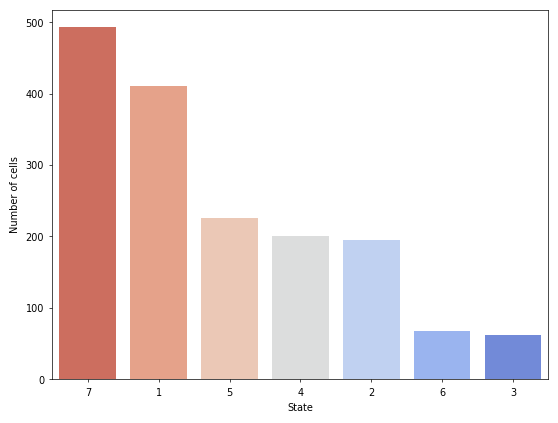

In [ ]:
MBCS_state = pd.read_csv("integrated/memoryS_state.csv", index_col="barcode")
MBCS_state['difference'] = new_adata.obs.loc[MBCS_state.index.tolist(),'difference']
state_count = {}
for s in MBCS_state.State.unique():
    large_num = MBCS_state[(MBCS_state.State == s)&(MBCS_state.difference == 'Large')].shape[0]
    small_num = MBCS_state[(MBCS_state.State == s)&(MBCS_state.difference == 'Small')].shape[0]
    state_count[s] = large_num / (large_num + small_num)

#state_count = {s:state_count[s] for s in [7, 5, 12, 13, 1]} 

sns.barplot(x = np.arange(len(MBCS_state.State.value_counts().values)), y = MBCS_state.State.value_counts().values, palette = "coolwarm_r")
plt.xlabel("State")
plt.xticks(np.arange(len(MBCS_state.State.value_counts().values)), MBCS_state.State.value_counts().index.tolist())
plt.ylabel("Number of cells")
#plt.savefig("/mnt/d/unifiedBCR/figures/PRJNA890633/State_cells.pdf", bbox_inches='tight', dpi=90)

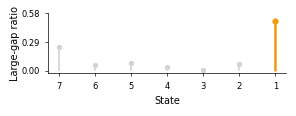

In [ ]:
state_count = {}
for s in MBCS_state.State.unique():
    large_num = MBCS_state[(MBCS_state.State == s)&(MBCS_state.difference == 'Large')].shape[0]
    small_num = MBCS_state[(MBCS_state.State == s)&(MBCS_state.difference == 'Small')].shape[0]
    state_count[s] = large_num / MBCS_state[MBCS_state.difference == 'Large'].shape[0]
    state_count = {k:state_count[k] for k in reversed(sorted(list(state_count.keys())))}
    
states = list(state_count.keys())
values = list(state_count.values())
x = np.arange(len(states))

plt.figure(figsize=(2.8, 1.0))

ymax = max(values) * 1.15

# 所有 state
plt.vlines(x, 0, values, color='lightgray', linewidth=1.2, zorder=1)
plt.scatter(x, values, color='lightgray', s=8, zorder=2)

i = states.index(1)
plt.vlines(x[i], 0, values[i], color='#F39C12', linewidth=1.8, zorder=3)
plt.scatter(x[i], values[i], color='#F39C12', s=12, zorder=4)

plt.xticks(x, [str(s) for s in states], fontsize=6)
plt.yticks(
    [0, round(ymax/2, 2), round(ymax, 2)],
    fontsize=6
)

plt.xlabel("State", fontsize=7)
plt.ylabel("Large-gap ratio", fontsize=7, labelpad=1)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout(pad=0.2)
plt.savefig(
    "/mnt/d/unifiedBCR/figures/PRJNA890633/State_lollipop.pdf",
    bbox_inches='tight'
)

In [5]:
from scipy.stats import fisher_exact, chi2_contingency

def count_kmers(sequences, k=2):
    kmer_dict = {}
    
    # Iterate through each sequence
    for seq in sequences:
        # Convert sequence to uppercase to standardize
        seq = seq.upper()[3:-3]
        
        # Slide through the sequence with window size k
        for i in range(len(seq) - k + 1):
            kmer = seq[i:i+k]
            # Add to dictionary or increment count
            kmer_dict[kmer] = kmer_dict.get(kmer, 0) + 1
            
    return kmer_dict

def compare_kmers(dict1, dict2, n_query_cdr3, n_ref_cdr3, alpha=0.05):
    """
    Compare k-mer frequencies between two dictionaries using Fisher's exact test
    
    Parameters:
    dict1 (dict): First k-mer dictionary
    dict2 (dict): Second k-mer dictionary
    alpha (float): Significance level for p-value cutoff (default: 0.05)
    
    Returns:
    pd.DataFrame: DataFrame containing k-mers, their counts, odds ratios, and p-values
    """
    # Get all unique k-mers
    all_kmers = sorted(set(list(dict1.keys()) + list(dict2.keys())))
    
    results = []
    
    # Perform Fisher's exact test for each k-mer
    for kmer in all_kmers:
        count1 = dict1.get(kmer, 0)
        count2 = dict2.get(kmer, 0)
        
        # Create contingency table
        contingency = np.array([[count1, n_query_cdr3 - count1],
                              [count2, n_ref_cdr3 - count2]])
        
        expected = np.array([n_query_cdr3*(count1+count2)/(n_query_cdr3+n_ref_cdr3), n_query_cdr3*(n_query_cdr3 - count1+n_ref_cdr3 - count2)/(n_query_cdr3+n_ref_cdr3),
              n_ref_cdr3*(count1+count2)/(n_query_cdr3+n_ref_cdr3), n_ref_cdr3*(n_query_cdr3 - count1+n_ref_cdr3 - count2)/(n_query_cdr3+n_ref_cdr3)])
        
        if np.sum(expected < 5) > 1:
            # Perform Fisher's exact test
            odds_ratio, pvalue = fisher_exact(contingency)
            test_used = 'Fisher'
        else:
            # Use Chi-square test
            odds_ratio, pvalue, _, _ = chi2_contingency(contingency)
            test_used = 'Chi-square'
        
        results.append({
            'kmer': kmer,
            'count1': count1,
            'count2': count2,
            'freq1': count1/(n_query_cdr3 - count1) if n_query_cdr3 > 0 else 0,
            'freq2': count2/(n_ref_cdr3 - count2) if n_ref_cdr3 > 0 else 0,
            'odds_ratio': odds_ratio,
            'pvalue': pvalue,
            'test_used': test_used,
            'significant': pvalue < alpha
        })
    
    # Convert to DataFrame and sort by p-value
    df = pd.DataFrame(results)
    df = df.sort_values('pvalue')
    df = df[df.pvalue <= alpha]
    
    return df

In [17]:
cohort = new_adata.obs[(new_adata.obs['sample'].isin(["CNMC89","CNMC71"]))&(new_adata.obs.celltypes=="Memory")&(new_adata.obs.difference=="Large")&(new_adata.obs.batch==6)].index.tolist()
control = new_adata.obs[(new_adata.obs['sample'].isin(["CNMC89","CNMC71"]))&(new_adata.obs.celltypes=="Memory")&(new_adata.obs.difference=="Small")&(new_adata.obs.batch==6)].index.tolist()

targetdict = count_kmers(bcrfile.loc[cohort, 'cdr3'].unique(), k=3)
controldict = count_kmers(list(set(bcrfile.loc[control, 'cdr3'].unique()) - set(bcrfile.loc[cohort, 'cdr3'].unique())), k=3)
result = compare_kmers(targetdict, controldict, len(bcrfile.loc[cohort, 'cdr3'].unique()), len(list(set(bcrfile.loc[control, 'cdr3'].unique()) - set(bcrfile.loc[cohort, 'cdr3'].unique()))), alpha=0.05)
result

,kmer,count1,count2,freq1,freq2,odds_ratio,pvalue,test_used,significant
4314,YYD,47,60,0.111374,0.051680,16.565271,0.000047,Chi-square,True
3178,SGY,48,62,0.113744,0.053402,16.508059,0.000048,Chi-square,True
1411,GYY,38,46,0.090047,0.039621,14.674994,0.000128,Chi-square,True
3163,SGF,9,2,0.021327,0.001723,14.514024,0.000139,Chi-square,True
4331,YYY,78,136,0.184834,0.117140,11.559130,0.000674,Chi-square,True
...,...,...,...,...,...,...,...,...,...
3174,SGS,18,26,0.042654,0.022394,3.981205,0.046011,Chi-square,True
4224,YPP,4,2,0.009479,0.001723,5.545455,0.046711,Fisher,True
565,DRT,4,2,0.009479,0.001723,5.545455,0.046711,Fisher,True
1406,GYR,4,2,0.009479,0.001723,5.545455,0.046711,Fisher,True


In [ ]:
cohort = new_adata.obs[(new_adata.obs['sample'].isin(["CNMC89","CNMC71"]))&(new_adata.obs.celltypes=="Memory")&(new_adata.obs.difference=="Large")&(new_adata.obs.batch==6)].index.tolist()
control = new_adata.obs[(new_adata.obs['sample'].isin(["CNMC89","CNMC71"]))&(new_adata.obs.celltypes=="Memory")&(new_adata.obs.difference=="Small")&(new_adata.obs.batch==6)].index.tolist()

targetdict = count_kmers(bcrfile.loc[cohort, 'cdr3'].unique(), k=4)
controldict = count_kmers(list(set(bcrfile.loc[control, 'cdr3'].unique()) - set(bcrfile.loc[cohort, 'cdr3'].unique())), k=4)
result = compare_kmers(targetdict, controldict, len(bcrfile.loc[cohort, 'cdr3'].unique()), len(list(set(bcrfile.loc[control, 'cdr3'].unique()) - set(bcrfile.loc[cohort, 'cdr3'].unique()))), alpha=0.05)
result

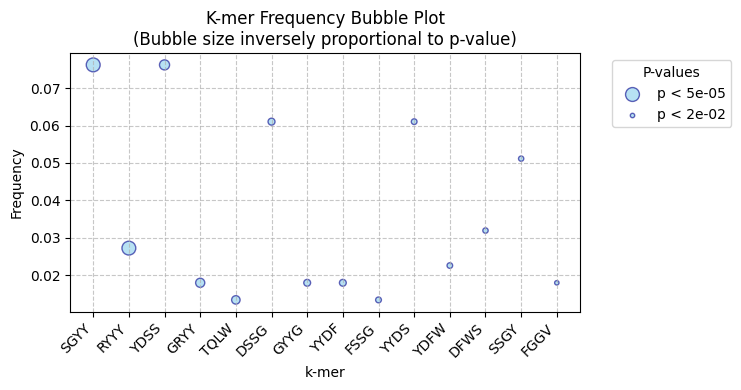

In [7]:
def create_bubble_plot(df, figsize=(6, 4), min_bubble_size=10, max_bubble_size=100):
    """
    Create a bubble plot where:
    - x-axis: kmers
    - y-axis: freq1
    - bubble size: inversely proportional to p-value (smaller p-values = larger bubbles)
    
    Parameters:
    df: DataFrame with columns 'kmer', 'freq1', 'pvalue'
    figsize: tuple for figure size
    min_bubble_size: minimum size for bubbles
    max_bubble_size: maximum size for bubbles
    """
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=figsize)
    
    # Calculate bubble sizes: -log10(pvalue) for better visualization
    # Add small constant to avoid log(0)
    sizes = -np.log10(df['pvalue'] + 1e-300)
    
    # Normalize sizes to desired range
    sizes_normalized = ((sizes - sizes.min()) * (max_bubble_size - min_bubble_size) / 
                       (sizes.max() - sizes.min()) + min_bubble_size)
    
    # Create scatter plot
    scatter = ax.scatter(range(len(df)), df['freq1'], 
                        s=sizes_normalized, 
                        alpha=0.6,
                        c='skyblue',
                        edgecolor='darkblue')
    
    # Customize plot
    ax.set_xticks(range(len(df)))
    ax.set_xticklabels(df['kmer'], rotation=45, ha='right')
    
    # Add labels and title
    ax.set_xlabel('k-mer')
    ax.set_ylabel('Frequency')
    ax.set_title('K-mer Frequency Bubble Plot\n(Bubble size inversely proportional to p-value)')
    
    # Add grid
    ax.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Add legend for bubble sizes
    legend_elements = [plt.scatter([], [], s=sizes_normalized.max(), 
                                 c='skyblue', alpha=0.6, 
                                 edgecolor='darkblue', 
                                 label=f'p < {df["pvalue"].min():.0e}'),
                      plt.scatter([], [], s=sizes_normalized.min(), 
                                c='skyblue', alpha=0.6, 
                                edgecolor='darkblue', 
                                label=f'p < {df["pvalue"].max():.0e}')]
    
    ax.legend(handles=legend_elements, 
             title='P-values',
             bbox_to_anchor=(1.05, 1),
             loc='upper left')
    
    return fig, ax


# Create the plot
#fig, ax = create_bubble_plot(pd.concat([result[:13], result[result["kmer"] == "YYGM"]]))
fig, ax = create_bubble_plot(result[:14])
plt.savefig("/mnt/d/unifiedBCR/figures/PRJNA890633/5thre_4mer.pdf", bbox_inches='tight')